In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb

# %matplotlib inline
plt.style.use('ggplot')
from IPython.display import display

# EDA
定位到目录

In [2]:
%pwd
#%cd Kaggle/Titanic/

'D:\\Projects\\DataAnalysis\\Kaggle\\Titanic-#1'

In [16]:
train = pd.read_csv('train.csv')
# 将 PassengerId 设置为index，它对于预测没有帮助
train.set_index('PassengerId', inplace=True)
display(train.head())
display(train.info())

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


None

特征说明：
+ Pclass：Ticket Class, 取值 1 = 1st, 2 = 2nd, 3 = 3rd
+ Name: 姓名
+ Sex: 性别
+ Age: 年龄
+ SibSp: 是否有兄弟(Silbings)或配偶(Spouse)同行
+ Parch: 是否有父母(Parents)或者子女(Children)同行
+ Ticket: 船票号码
+ Fare: 船票费用
+ Cabin: 船舱编号
+ Embarked: 登船的码头，C = Cherbourg, Q = Queenstown, S = Southampton

预测变量：Survived: 0=No, 1=Yes

二分类问题，根据直觉，先检查下各个特征在预测变量上的分布。

In [17]:
# 为了方便绘图，需要对一些离散特征的类型做一下转换
train = train.astype({'Survived': str})
train.info()

TypeError: Neither the `x` nor `y` variable appears to be numeric.

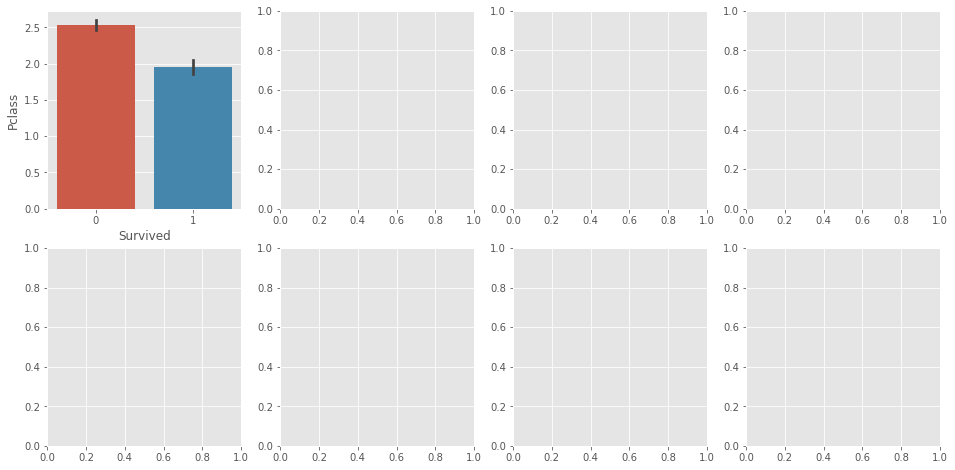

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
sns.barplot(data=train, x='Survived', y='Pclass', ax=axes[0,0])
sns.barplot(data=train, x='Survived', y='Sex', ax=axes[0,1])

In [5]:
sns.

AttributeError: 'numpy.ndarray' object has no attribute 'bar'